In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.basic_train import *
from fastai.vision.learner import *
import pandas as pd
import numpy as np
import cv2

from efficientnet_pytorch import EfficientNet

In [3]:
df = pd.read_csv('../Data/Old_data/UnimodalLabels.csv').fillna('')#.iloc[:100,:]

In [4]:
old_stats = ([0.7229, 0.6502, 0.6050], [0.1622, 0.1431, 0.1128])
def get_data(size=224,bs=32):
    np.random.seed(420)
    
    tfms = [[rotate(degrees=(-5,5),p=0.5),
         flip_lr(p=0.5),
         contrast(scale=(0.7,1),p=0.5)],[]]
    tfms[0].extend(rand_resize_crop(size,max_scale=2))
    
    data = (ImageList.from_df(df,'../Data/Old_data/train_processed')
    .split_by_rand_pct(valid_pct=0.1)
    .label_from_df(cols='level')
    .transform(tfms, size=size)
    .databunch(bs=bs)).normalize(old_stats)
# #         ds_tfms=tfms,
# #         size=size,
# #         bs = bs,
# #         label_delim = ',',
# #         valid_pct = 0.1,
# #         num_workers = os.cpu_count() 
#     )#.normalize(old_stats)
    
    return data

In [5]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=5).cuda()
learn = Learner(get_data(448,16),
                model,
                wd=1e-5,
                callback_fns=[ShowGraph,
#                               OverSamplingCallback,
                              partial(SaveModelCallback, every='epoch', monitor='kappa_score', name='epoch'),
                              partial(SaveModelCallback, every='improvement', monitor='kappa_score', name='classification_best_kappa', mode='max'),
                              partial(AccumulateScheduler, n_step=2)
#                               partial(GradientAccumulator, num_iterations=2)
                             ],
                metrics=[accuracy,
                         KappaScore('quadratic')
                        ],
                loss_func=CrossEntropyFlat(reduction='sum')
               )
learn.to_fp16()
learn.mixup()
learn.load('epoch_6')
learn.unfreeze()

Loaded pretrained weights for efficientnet-b4


In [6]:
def do_fit(learner, epochs, lr, start_epoch=0, name='B4_Class', res=224, bs=16, div=25):
#     learner.data = get_data(size=res,bs=bs)
#     learner.to_fp16()
#     learner.mixup(stack_y=False)
    learner.fit_one_cycle(epochs, lr, pct_start=0.3, div_factor=div, start_epoch=start_epoch)
    learner.save(name+'_'+str(res)+'_'+str(start_epoch+epochs))
    print('Model saved as '+name+'_'+str(res)+'_'+str(start_epoch+epochs))

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.747009,0.715442,0.780057,0.532898,12:47
1,0.726309,0.879842,0.778063,0.487935,12:48
2,0.698572,0.727177,0.775214,0.608331,12:49
3,0.720712,1.060087,0.652422,0.370455,13:10
4,0.700791,0.670800,0.792308,0.643925,12:49
5,0.694176,0.597828,0.810541,0.639988,12:46
6,0.687290,0.600355,0.806553,0.686976,12:48


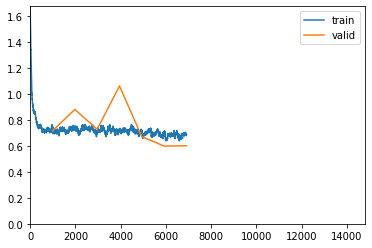

Better model found at epoch 0 with kappa_score value: 0.5328977108001709.
Better model found at epoch 2 with kappa_score value: 0.6083310842514038.
Better model found at epoch 4 with kappa_score value: 0.6439250707626343.
Better model found at epoch 6 with kappa_score value: 0.6869758367538452.


Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", 

KeyboardInterrupt: 

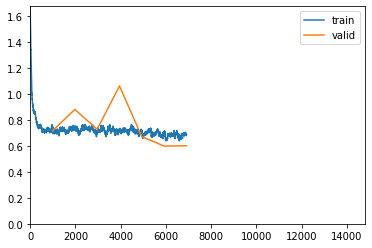

In [7]:
do_fit(learn, 15, 3e-3, bs=32)

Loaded epoch_6
Model classification_best_kappa_6 not found.


epoch,train_loss,valid_loss,accuracy,kappa_score,time
7,0.689024,0.567946,0.813390,0.692725,13:06
8,0.655497,0.594345,0.809402,0.620250,13:01
9,0.627856,0.550831,0.820513,0.711973,12:52
10,0.625528,0.522615,0.833333,0.733783,13:00
11,0.591596,0.511189,0.834188,0.763816,12:50
12,0.581888,0.503076,0.838462,0.769255,12:51
13,0.617234,0.498464,0.838462,0.775910,12:50
14,0.558490,0.497187,0.837892,0.772900,12:49


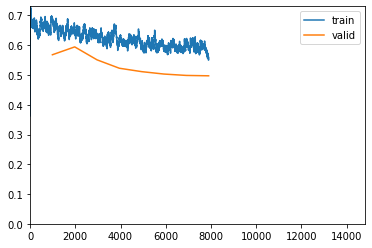

Better model found at epoch 7 with kappa_score value: 0.6927254796028137.
Better model found at epoch 9 with kappa_score value: 0.7119731307029724.
Better model found at epoch 10 with kappa_score value: 0.7337832450866699.
Better model found at epoch 11 with kappa_score value: 0.7638160586357117.
Better model found at epoch 12 with kappa_score value: 0.7692552804946899.
Better model found at epoch 13 with kappa_score value: 0.7759097218513489.
Model saved as B4_Class_224_22


In [16]:
do_fit(learn, 15, 3e-3, bs=32, start_epoch=7)

In [45]:
learn.validate()

[1.6434115, tensor(0.0917), tensor(0.0043)]

/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/train.py:109: UserWarning: For better gradients consider 'reduction=sum'
  warn("For better gradients consider 'reduction=sum'")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 3.98E-07


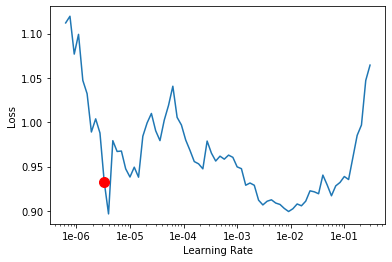

In [7]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

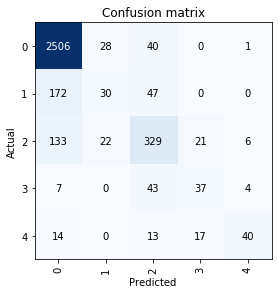

In [14]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(k=20)

In [ ]:
interp.most_confused(5)

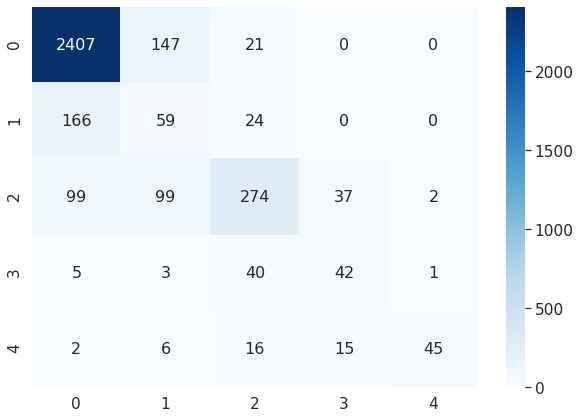

In [86]:
cm = np.array([
        [2.4070e+03, 1.4700e+02, 2.1000e+01, 0.0000e+00, 0.0000e+00],
        [1.6600e+02, 5.9000e+01, 2.4000e+01, 0.0000e+00, 0.0000e+00],
        [9.9000e+01, 9.9000e+01, 2.7400e+02, 3.7000e+01, 2.0000e+00],
        [5.0000e+00, 3.0000e+00, 4.0000e+01, 4.2000e+01, 1.0000e+00],
        [2.0000e+00, 6.0000e+00, 1.6000e+01, 1.5000e+01, 4.5000e+01]],dtype=np.int32)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
       
df_cm = pd.DataFrame(cm, range(5),range(5))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},cmap='Blues',fmt='d')# font size
# cm

## 416,416

epoch,train_loss,valid_loss,accuracy_thresh,multi_kappa_score,time
0,0.247623,0.223341,0.761881,0.701742,28:33
1,0.292381,0.253831,0.748718,0.756761,28:59
2,0.270730,0.235782,0.741710,0.784496,28:56
3,0.311924,0.285410,0.741710,0.798470,29:02
4,0.264610,0.275135,0.741881,0.808978,29:02
5,0.348088,0.337233,0.738803,0.816674,28:59
6,0.345620,0.329226,0.739145,0.819928,29:01
7,0.444740,0.408625,0.741709,0.820955,29:03
8,0.384350,0.402895,0.741709,0.823224,29:01
9,0.370993,0.358039,0.741026,0.822736,29:09


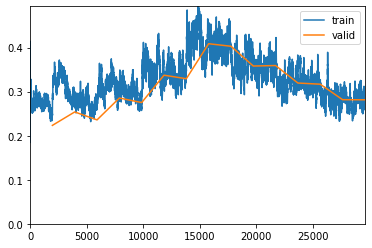

Better model found at epoch 0 with multi_kappa_score value: 0.7017415761947632.
Changing phi to: 1.7600000000000002
Better model found at epoch 1 with multi_kappa_score value: 0.7567606568336487.
Better model found at epoch 2 with multi_kappa_score value: 0.7844961285591125.
Changing phi to: 1.9360000000000004
Better model found at epoch 3 with multi_kappa_score value: 0.7984703183174133.
Better model found at epoch 4 with multi_kappa_score value: 0.8089778423309326.
Changing phi to: 2.1296000000000004
Better model found at epoch 5 with multi_kappa_score value: 0.8166738152503967.
Better model found at epoch 6 with multi_kappa_score value: 0.8199284076690674.
Changing phi to: 2.3425600000000006
Better model found at epoch 7 with multi_kappa_score value: 0.8209550976753235.
Better model found at epoch 8 with multi_kappa_score value: 0.8232238292694092.
Changing phi to: 2.2254320000000005
Changing phi to: 2.1141604000000003
Better model found at epoch 11 with multi_kappa_score value: 0.8

In [22]:
do_fit(learn, 15, 2e-5, res=448, bs=16)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.793642,0.664647,0.785470,0.397008,28:35
1,0.665268,0.529984,0.829060,0.696810,28:56
2,0.609282,0.503658,0.835613,0.733986,28:43
3,0.667810,0.487891,0.840741,0.760211,28:35
4,0.601675,0.480377,0.843590,0.768718,28:38
5,0.614212,0.476317,0.845299,0.773294,29:42
6,0.634061,0.475714,0.846154,0.768680,30:49


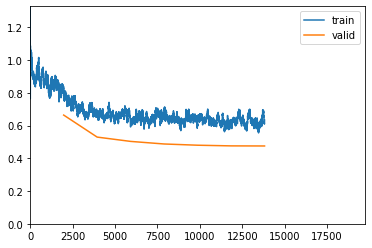

Better model found at epoch 0 with kappa_score value: 0.39700764417648315.
Better model found at epoch 1 with kappa_score value: 0.6968103051185608.
Better model found at epoch 2 with kappa_score value: 0.7339861989021301.
Better model found at epoch 3 with kappa_score value: 0.7602114677429199.
Better model found at epoch 4 with kappa_score value: 0.7687175273895264.
Better model found at epoch 5 with kappa_score value: 0.773293673992157.


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 319, in reduce_storage
    df = multiprocessing.reduction.DupFd(fd)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/mult

FileNotFoundError: [Errno 2] No usable temporary directory found in ['/tmp', '/var/tmp', '/usr/tmp', '/home/atom/models']
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 229, in _get_default_tempdir
    dirlist)
FileNotFoundError: [Errno 2] No usable temporary directory found in ['/tmp', '/var/tmp', '/usr/tmp', '/home/atom/models']
Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 319, in reduce_storage
    df = multiprocessing.reduction.DupFd(fd)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/reduction.py", line 194, in DupFd
    return resource_sharer.DupFd(fd)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocess

  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 356, in mkdtemp
    prefix, suffix, dir, output_type = _sanitize_params(prefix, suffix, dir)
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 126, in _sanitize_params
    dir = gettempdir()
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 294, in gettempdir
    tempdir = _get_default_tempdir()
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 229, in _get_default_tempdir
    dirlist)
FileNotFoundError: [Errno 2] No usable temporary directory found in ['/tmp', '/var/tmp', '/usr/tmp', '/home/atom/models']
Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/multiprocessing/reductions.

  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 76, in arbitrary_address
    return tempfile.mktemp(prefix='listener-', dir=util.get_temp_dir())
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/util.py", line 114, in get_temp_dir
    tempdir = tempfile.mkdtemp(prefix='pymp-')
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 356, in mkdtemp
    prefix, suffix, dir, output_type = _sanitize_params(prefix, suffix, dir)
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 126, in _sanitize_params
    dir = gettempdir()
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 294, in gettempdir
    tempdir = _get_default_tempdir()
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 229, in _get_default_tempdir
    dirlist)
FileNotFoundError: [Errno 2] No usable temporary directory found in ['/tmp', '/var/tmp', '/usr/tmp', '/home/atom/models']


KeyboardInterrupt: 

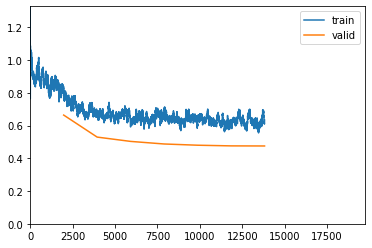

In [9]:
do_fit(learn, 10, 3e-5, res=448, bs=16)

Loaded epoch_6
Model classification_best_kappa_6 not found.


epoch,train_loss,valid_loss,accuracy,kappa_score,time
7,0.650326,0.473203,0.846154,0.774957,30:57
8,0.622692,0.473130,0.845584,0.772583,30:55
9,0.632574,0.473580,0.847009,0.776157,29:16


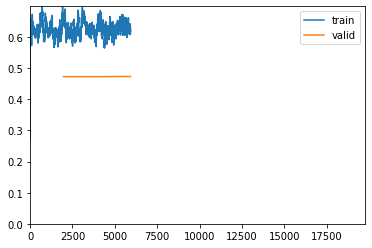

Better model found at epoch 7 with kappa_score value: 0.7749566435813904.
Better model found at epoch 9 with kappa_score value: 0.7761572599411011.
Model saved as B4_Class_448_17


In [7]:
do_fit(learn, 10, 3e-5, res=448, bs=16, start_epoch=7)

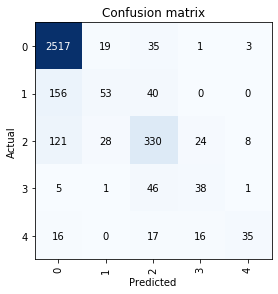

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [9]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
!sudo shutdown -h 1

In [15]:
gc.collect()

169